In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import pytorch_lightning as pl

from torch_geometric.data import DataLoader
import pytorch_lightning as pl
import os.path as osp

from tqdm import tqdm

from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

In [2]:
%cd ..

/nfs/homedirs/fuchsgru/MastersThesis


In [3]:
import configuration
import model_registry
import data.build
import data.constants as dconst
from data.util import data_get_num_attributes, data_get_num_classes
from model.semi_supervised_node_classification import SemiSupervisedNodeClassification, Ensemble
from evaluation.util import get_data_loader, run_model_on_datasets, separate_distributions
import evaluation.callbacks as ecbs
from metrics import expected_calibration_error
from plot.calibration import plot_calibration
from data.util import label_binarize
from model.density import get_density_model
import seed
from train import train_model
from model.build import make_model

In [4]:
import logging as l

l.basicConfig(level=l.INFO)

In [6]:
dataset = dconst.CORA_FULL

spectral_norm_conf = {'model' : {
        'use_spectral_norm' : True,
        'residual' : True,
        'weight_scale' : 200.0,
    },}

reco_conf = {
    'model' : {
        'reconstruction' : {
            'loss_weight' : 1.0,
            'reconstruction_type' : 'energy',
        },
    },
}

config = configuration.ExperimentConfiguration(
    data={
        'dataset' : dataset,
        'setting' : dconst.HYBRID,
        'ood_type' : dconst.PERTURBATION,
        'use_dataset_registry' : False,
    },
    # **spectral_norm_conf,
    run = {
        'use_default_configuration' : True,
    },
)
config_norm = configuration.ExperimentConfiguration(
    data={
        'dataset' : dataset,
        'setting' : dconst.HYBRID,
        'ood_type' : dconst.PERTURBATION,
        'use_dataset_registry' : False,
    },
    **spectral_norm_conf,
    run = {
        'use_default_configuration' : True,
    },
)

config_reco = configuration.ExperimentConfiguration(
    data={
        'dataset' : dataset,
        'setting' : dconst.HYBRID,
        'ood_type' : dconst.PERTURBATION,
        'use_dataset_registry' : False,
    },
    **reco_conf,
    run = {
        'use_default_configuration' : True,
    },
)

if config.run.use_default_configuration:
    configuration.update_with_default_configuration(config)
    configuration.update_with_default_configuration(config_norm)
    configuration.update_with_default_configuration(config_reco)
    
print(config.run.use_default_configuration)

INFO:root:Set configuration value data.base_labels to default ['Artificial_Intelligence/Machine_Learning/Case-Based', 'Artificial_Intelligence/Machine_Learning/Theory', 'Artificial_Intelligence/Machine_Learning/Genetic_Algorithms', 'Artificial_Intelligence/Machine_Learning/Probabilistic_Methods', 'Artificial_Intelligence/Machine_Learning/Neural_Networks', 'Artificial_Intelligence/Machine_Learning/Rule_Learning', 'Artificial_Intelligence/Machine_Learning/Reinforcement_Learning', 'Operating_Systems/Distributed', 'Operating_Systems/Memory_Management', 'Operating_Systems/Realtime', 'Operating_Systems/Fault_Tolerance']
INFO:root:Set configuration value data.corpus_labels to default ['Artificial_Intelligence/Machine_Learning/Case-Based', 'Artificial_Intelligence/Machine_Learning/Theory', 'Artificial_Intelligence/Machine_Learning/Genetic_Algorithms', 'Artificial_Intelligence/Machine_Learning/Probabilistic_Methods', 'Artificial_Intelligence/Machine_Learning/Neural_Networks', 'Artificial_Intell

INFO:root:Set configuration value data.left_out_class_labels to default ['Operating_Systems/Distributed', 'Operating_Systems/Memory_Management', 'Operating_Systems/Realtime', 'Operating_Systems/Fault_Tolerance']
INFO:root:Set configuration value data.preprocessing to default none
INFO:root:Set configuration value data.ood_sampling_strategy to default all
INFO:root:Set configuration value data.train_portion to default 20
INFO:root:Set configuration value data.test_portion_fixed to default 0.2
INFO:root:Set configuration value data.split_type to default uniform
INFO:root:Set configuration value data.type to default npz
INFO:root:Set configuration value data.drop_train_vertices_portion to default 0.1
INFO:root:Set configuration value data.precompute_k_hop_neighbourhood to default 2
INFO:root:Set configuration value model.hidden_sizes to default [64]
INFO:root:Set configuration value data.base_labels to ['Artificial_Intelligence/Machine_Learning/Case-Based', 'Artificial_Intelligence/Machin

True


In [7]:
config.data.setting

'hybrid'

In [8]:
data_split_seed = seed.data_split_seeds()[config.run.split_idx]
config.registry.split_seed = data_split_seed
model_seed_generator = iter(seed.SeedIterator(seed.model_seeds()[config.run.initialization_idx]))
data_dict, fixed_vertices = data.build.load_data_from_configuration(config.data, data_split_seed)
data_loaders = {
    name : DataLoader(data, batch_size=1, shuffle=False) for name, data in data_dict.items()
}

INFO:root:Did not find precomputed dataset split.
INFO:root:Data Loading - Loaded adjacency matrix.
INFO:root:Data Loading - Built attribute matrix.


Build SingleGraphDataset with additional attribute dict_keys(['feature_to_idx'])
Build SingleGraphDataset with additional attribute dict_keys(['feature_to_idx'])


INFO:root:Precompute <= 2 neighbourhoods of ood graph.


Build SingleGraphDataset with additional attribute dict_keys(['feature_to_idx'])
Build SingleGraphDataset with additional attribute dict_keys(['feature_to_idx'])
Build SingleGraphDataset with additional attribute dict_keys(['feature_to_idx'])
Build SingleGraphDataset with additional attribute dict_keys(['is_train_graph_vertex', 'feature_to_idx', '0_hop_neighbourhood_indptr', '0_hop_neighbourhood_indices', '1_hop_neighbourhood_indptr', '1_hop_neighbourhood_indices', '2_hop_neighbourhood_indptr', '2_hop_neighbourhood_indices'])
Build SingleGraphDataset with additional attribute dict_keys(['is_train_graph_vertex', 'feature_to_idx', '0_hop_neighbourhood_indptr', '0_hop_neighbourhood_indices', '1_hop_neighbourhood_indptr', '1_hop_neighbourhood_indices', '2_hop_neighbourhood_indptr', '2_hop_neighbourhood_indices'])


/nfs/homedirs/fuchsgru/miniconda3/lib/python3.9/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [9]:
_ = data_dict[dconst.TRAIN][0].feature_to_idx

In [10]:
(data_dict[dconst.TRAIN][0].x > 0).float().mean(1).mean(0)

tensor(0.0064)

In [11]:
model_seed = next(model_seed_generator)

In [12]:
run_artifact_dir = artifact_dir = osp.join(config.logging.artifact_dir, 'spectral-structure')

In [14]:
config.run.use_pretrained_model = False # We need to re-train the models
config_norm.run.use_pretrained_model = False # We need to re-train the models
config_reco.run.use_pretrained_model = False # We need to re-train the models

In [17]:
if not torch.cuda.is_available():
    config.training.gpus = 0
    config_norm.training.gpus = 0
    config_reco.training.gpus = 0
config.training.gpus, config_norm.training.gpus, config_reco.training.gpus

(0, 0, 0)

In [18]:
# Create a callback that logs the weight matrix svd
from collections import defaultdict

class LogWeightMatrixSpectrum(pl.callbacks.Callback):
    """ Finds all weight matrices and logs their spectrum every epoch. """

    def __init__(self, log_every_epoch=1):
        super().__init__()
        self.log_every_epoch = log_every_epoch
        self._buffer = defaultdict(list)
        self._epoch_buffer = []

    def on_validation_epoch_start(self, trainer: pl.Trainer, model: pl.LightningModule):
        if trainer.global_step % self.log_every_epoch == 0:
            self._epoch_buffer.append(trainer.global_step)
            weights = model.get_weights()
            for name, weight in weights.items():
                u, s, v = np.linalg.svd(weight.detach().cpu().numpy(), full_matrices=False)
                self._buffer[name].append((u, s, v))

In [19]:
svd_callback, svd_callback_norm, svd_callback_reco = LogWeightMatrixSpectrum(), LogWeightMatrixSpectrum(), LogWeightMatrixSpectrum()

In [22]:
config.registry.model_seed = model_seed
pl.seed_everything(model_seed)
model = make_model(config, data_get_num_attributes(data_dict[dconst.TRAIN][0]), 
    data_get_num_classes(data_dict[dconst.TRAIN][0]))
print(model)
model = train_model(model, config, artifact_dir, data_loaders, logger=None, callbacks=[svd_callback]).eval()

Global seed set to 1952926171
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name     | Type | Params
----------------------------------
0 | backbone | GCN  | 557 K 
----------------------------------
557 K     Trainable params
0         Non-trainable params
557 K     Total params
2.232     Total estimated model params size (MB)


SemiSupervisedNodeClassification(
  (backbone): GCN(
    (convs): ModuleList(
      (0): BasicBlock(
        (conv): GCNConv
          LinearWithParametrization(
            (linear): Linear(in_features=8710, out_features=64, bias=False)
          )
        (act): LeakyReLU(negative_slope=0.01)
      )
      (1): BasicBlock(
        (conv): GCNConv
          LinearWithParametrization(
            (linear): Linear(in_features=64, out_features=7, bias=False)
          )
      )
    )
  )
)


Global seed set to 1952926171
INFO:root:Best model path after training is /nfs/students/fuchsgru/artifacts/spectral-structure/epoch=999-step=999.ckpt
INFO:root:Paths ['/nfs/students/fuchsgru/model_registry/1534242312.ckpt'] were overwritten with /nfs/students/fuchsgru/artifacts/spectral-structure/epoch=999-step=999.ckpt


In [23]:
config_norm.registry.model_seed = model_seed
pl.seed_everything(model_seed)
model_norm = make_model(config_norm, data_get_num_attributes(data_dict[dconst.TRAIN][0]), 
    data_get_num_classes(data_dict[dconst.TRAIN][0]))
print(model_norm)
model_norm = train_model(model_norm, config_norm, artifact_dir, data_loaders, logger=None, callbacks=[svd_callback_norm]).eval()

Global seed set to 1952926171
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name     | Type | Params
----------------------------------
0 | backbone | GCN  | 1.1 M 
----------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.461     Total estimated model params size (MB)


SemiSupervisedNodeClassification(
  (backbone): GCN(
    (convs): ModuleList(
      (0): ResidualBlock(
        (conv): GCNConv
          LinearWithParametrization(
            (linear): ParametrizedLinear(
              in_features=8710, out_features=64, bias=False
              (parametrizations): ModuleDict(
                (weight): ParametrizationList(
                  (0): SpectralNorm(rescaling=200.0, n_iter=1)
                )
              )
            )
          )
        (act): LeakyReLU(negative_slope=0.01)
        (input_projection): LinearWithParametrization(
          (linear): ParametrizedLinear(
            in_features=8710, out_features=64, bias=False
            (parametrizations): ModuleDict(
              (weight): ParametrizationList(
                (0): SpectralNorm(rescaling=200.0, n_iter=1)
              )
            )
          )
        )
      )
      (1): BasicBlock(
        (conv): GCNConv
          LinearWithParametrization(
            (linear): Li

Global seed set to 1952926171
INFO:root:Best model path after training is /nfs/students/fuchsgru/artifacts/spectral-structure/epoch=2-step=2-v1.ckpt
INFO:root:Paths ['/nfs/students/fuchsgru/model_registry/2804271064.ckpt'] were overwritten with /nfs/students/fuchsgru/artifacts/spectral-structure/epoch=2-step=2-v1.ckpt


In [24]:
config_reco.registry.model_seed = model_seed
pl.seed_everything(model_seed)
model_reco = make_model(config_reco, data_get_num_attributes(data_dict[dconst.TRAIN][0]), 
    data_get_num_classes(data_dict[dconst.TRAIN][0]))
print(model_reco)
model_reco = train_model(model_reco, config_reco, artifact_dir, data_loaders, logger=None, callbacks=[svd_callback_reco]).eval()

Global seed set to 1952926171
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name                | Type               | Params
-----------------------------------------------------------
0 | backbone            | GCN                | 557 K 
1 | reconstruction_loss | ReconstructionLoss | 0     
-----------------------------------------------------------
557 K     Trainable params
0         Non-trainable params
557 K     Total params
2.232     Total estimated model params size (MB)


SemiSupervisedNodeClassification(
  (backbone): GCN(
    (convs): ModuleList(
      (0): BasicBlock(
        (conv): GCNConv
          LinearWithParametrization(
            (linear): Linear(in_features=8710, out_features=64, bias=False)
          )
        (act): LeakyReLU(negative_slope=0.01)
      )
      (1): BasicBlock(
        (conv): GCNConv
          LinearWithParametrization(
            (linear): Linear(in_features=64, out_features=7, bias=False)
          )
      )
    )
  )
  (reconstruction_loss): ReconstructionLoss()
)


Global seed set to 1952926171
INFO:root:Best model path after training is /nfs/students/fuchsgru/artifacts/spectral-structure/epoch=876-step=876.ckpt


In [25]:
svd_callback._buffer.keys(), svd_callback_norm._buffer.keys()

(dict_keys(['backbone.conv0.lin.weight', 'backbone.conv1.lin.weight']),
 dict_keys(['backbone.conv0.lin.weight', 'backbone.conv0.residual_projection.weight', 'backbone.conv1.lin.weight']))

In [26]:
svs = {
    k : np.array([s for u, s, v in buf]) for k, buf in svd_callback._buffer.items()
}
svs_norm = {
    k : np.array([s for u, s, v in buf]) for k, buf in svd_callback_norm._buffer.items()
}
svs_reco = {
    k : np.array([s for u, s, v in buf]) for k, buf in svd_callback_reco._buffer.items()
}

In [27]:
svs.keys(), svs_norm.keys(), svs_reco.keys()

(dict_keys(['backbone.conv0.lin.weight', 'backbone.conv1.lin.weight']),
 dict_keys(['backbone.conv0.lin.weight', 'backbone.conv0.residual_projection.weight', 'backbone.conv1.lin.weight']),
 dict_keys(['backbone.conv0.lin.weight', 'backbone.conv1.lin.weight']))

In [28]:
from typing import Tuple, Any, Optional
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

def plot_histogram_evolution(values: np.ndarray, num_bins: int = 25, figsize: Tuple[float, float]=(10, 5), value_name: Optional[str]=None,
        time_name: Optional[str]='Epoch', time_interval: int=1) -> Tuple[plt.Figure, Any]:
    """ Plots the evolution of a 1d distribution as a 2d heatmap with time on the x axis.
    
    Parameters:
    -----------
    values : ndarray, shape [sequence_length, num_observations]
        The observations to plot the distribution of.
    num_bins : int, optional, default: 25
        How many bins to use for the observations.
    figsize : Tuple[float, float], optional, default: (10, 5)
        The size of the plt figure.
    value_name : str, optional, default: None
        If given, what the observations are called.
    time_name : str, optional, default: 'Epoch'
        If given, what the temporal axis should be labeled with.
    time_interval : int, optional, default: 1
        The step in which the temporal x axis goes.
    
    Returns:
    --------
    fig : plt.Figure
        The figure.
    ax : plt.axes.Axes
        The axis.
    """ 
    bin_centers = np.linspace(np.round(values.min() - 0.5, 0), np.round(values.max() + 0.5, 0), num_bins)

    distances = np.abs(values.flatten()[:, None] - bin_centers[None, :])
    bin_idxs = distances.argmin(1).reshape(values.shape)

    counts = np.zeros((num_bins, values.shape[0]))
    for epoch in range(values.shape[0]):
        for bin_idx in bin_idxs[epoch]:
            counts[bin_idx, epoch] += 1

    counts = pd.DataFrame(counts, index=np.round(bin_centers, 2), columns=[i * time_interval for i in range(values.shape[0])])
    if value_name:
        counts.index.name = value_name
    if time_name:
        counts.columns.name = time_name

    fig, ax = plt.subplots(figsize=figsize)
    
    viridis = cm.get_cmap('viridis', 256)
    newcolors = viridis(np.linspace(0, 1, 256))
    newcolors[:1, :] = [1, 1, 1, 1]
    newcmp = ListedColormap(newcolors)
    
    sns.heatmap(counts, robust=True, ax=ax, cmap=newcmp, cbar_kws={'label' : 'Count'})
    return fig, ax


In [29]:
def counts(values, num_bins=25):
    bin_centers = np.linspace(np.round(values.min() - 0.5, 0), np.round(values.max() + 0.5, 0), num_bins)

    distances = np.abs(values.flatten()[:, None] - bin_centers[None, :])
    bin_idxs = distances.argmin(1).reshape(values.shape)

    counts = np.zeros((num_bins, values.shape[0]))
    for epoch in range(values.shape[0]):
        for bin_idx in bin_idxs[epoch]:
            counts[bin_idx, epoch] += 1

    counts = pd.DataFrame(counts, index=np.round(bin_centers, 2), columns=[i for i in range(values.shape[0])])
    return counts
    

In [30]:
def plot_heatmap2d(ax: Any, values: np.ndarray, figsize: Tuple[float, float]=(10, 5), value_name: Optional[str]=None,
        time_name: Optional[str]='Epoch', time_interval: int=1, log_scale: bool=True, cbar_label: Optional[str]=None) -> Tuple[plt.Figure, Any]:
    """ Plots a 2d heatmap.
    
    Parameters:
    -----------
    values : ndarray, shape [sequence_length, num_observations]
        The observations to plot the distribution of.
    figsize : Tuple[float, float], optional, default: (10, 5)
        The size of the plt figure.
    value_name : str, optional, default: None
        If given, what the observations are called.
    time_name : str, optional, default: 'Epoch'
        If given, what the temporal axis should be labeled with.
    time_interval : int, optional, default: 1
        The step in which the temporal x axis goes.
    
    Returns:
    --------
    fig : plt.Figure
        The figure.
    ax : plt.axes.Axes
        The axis.
    """ 
    if log_scale:
        values = np.log(values)
        if cbar_label:
            cbar_label = f'Log {cbar_label}'
    df = pd.DataFrame(values.T, columns=time_interval * np.arange(values.shape[0]))
    if value_name:
        df.index.name = value_name
    if time_name:
        df.columns.name = time_name
    if cbar_label:
        cbar_kwargs = {
            'label' : cbar_label
        }
    else:
        cbar_kwargs = {}
    sns.heatmap(df, ax=ax, cbar_kws=cbar_kwargs, cmap='viridis')
    return fig, ax

In [31]:
def despine(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

Text(0.5, 1.0, 'GCN + Spectral Norm.')

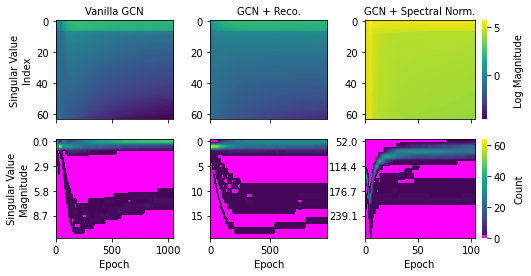

In [45]:
eps = 0.08
fig, axs = plt.subplots(2, 3, sharey=False, sharex='col', figsize=(8, 4),
    gridspec_kw = {'width_ratios' : [1.0 - eps, 1.0 - eps, 1.0 + eps], 'wspace' : 0.3}
                       )

# Upper row, individual values
log_svs = np.log(svs['backbone.conv0.lin.weight'])
log_svs_norm = np.log(svs_norm['backbone.conv0.lin.weight'])
log_svs_reco = np.log(svs_reco['backbone.conv0.lin.weight'])

vmin, vmax = min(log_svs.min(), log_svs_norm.min(), log_svs_reco.min()), max(log_svs.max(), log_svs_norm.max(), log_svs_reco.max())

axs[0, 0].imshow(log_svs[:-1].T, cmap='viridis', vmin=vmin, vmax=vmax, aspect='auto')
# despine(axs[0, 0])
axs[0, 1].imshow(log_svs_reco[:-1].T, cmap='viridis', vmin=vmin, vmax=vmax, aspect='auto')
im = axs[0, 2].imshow(log_svs_norm[:-1].T, cmap='viridis', vmin=vmin, vmax=vmax, aspect='auto')
# despine(axs[0, 1])
cbar = fig.colorbar(im, ax=axs[0, 2])
cbar.set_label('Log Magnitude', labelpad=14)
cbar.outline.set_visible(False)
cbar.solids.set_edgecolor("face")

#sns.heatmap(log_svs.T, ax=axs[0, 0], cmap='viridis', vmin=vmin, vmax=vmax, cbar=False, linewidths=0)
#sns.heatmap(log_svs_norm.T, ax=axs[0, 1], cmap='viridis', vmin=vmin, vmax=vmax, cbar_kws={'label' : 'Log Magnitude'}, linewidths=0)
axs[0, 0].set_ylabel('Singular Value\nIndex')

# Lower row, histogram of values


viridis = cm.get_cmap('viridis', 256)
newcolors = viridis(np.linspace(0, 1, 256))
newcolors[:1, :-1] = [1, 0, 1]
newcmp = ListedColormap(newcolors)


num_bins = 20
sv_count = counts(svs['backbone.conv0.lin.weight'], num_bins=num_bins)
sv_count_norm = counts(svs_norm['backbone.conv0.lin.weight'], num_bins=num_bins)
sv_count_reco = counts(svs_reco['backbone.conv0.lin.weight'], num_bins=num_bins)
bins_count, bins_count_norm, bin_count_reco = sv_count.index.to_numpy(), sv_count_norm.index.to_numpy(), sv_count_reco.index.to_numpy()

vmin = min(sv_count.to_numpy().min(), sv_count_norm.to_numpy().min(), sv_count_reco.to_numpy().min())
vmax = max(sv_count.to_numpy().max(), sv_count_norm.to_numpy().max(), sv_count_reco.to_numpy().max())

# Hacky way to get a nicer cbar
newcolors_2 = newcolors.copy()
newcolors_2[:10, :-1] = [1, 0, 1] # More space for the purple
im_cbar = axs[1, 2].imshow(np.zeros_like(sv_count), cmap=ListedColormap(newcolors_2), aspect='auto', vmin=vmin, vmax=vmax)


axs[1, 0].imshow(sv_count.to_numpy()[:, :-1], cmap=newcmp, aspect='auto', vmin=vmin, vmax=vmax)
#despine(axs[1, 0])
axs[1, 1].imshow(sv_count_reco.to_numpy()[:, :-1], cmap=newcmp, aspect='auto', vmin=vmin, vmax=vmax)
im = axs[1, 2].imshow(sv_count_norm.to_numpy()[:, :-1], cmap=newcmp, aspect='auto', vmin=vmin, vmax=vmax)
#despine(axs[1, 1])
cbar = fig.colorbar(im_cbar, ax=axs[1, 2])
cbar.set_label('Count', labelpad=8)
cbar.outline.set_visible(False)
cbar.solids.set_edgecolor("face")


#sns.heatmap(sv_count, ax=axs[1, 0], cmap=newcmp, cbar=False, xticklabels=250, linewidths=0)
#sns.heatmap(sv_count_norm, ax=axs[1, 1], cmap=newcmp, cbar_kws={'label' : 'Count'}, xticklabels=100, linewidths=0)

yticks = list(range(0, num_bins, 5))
axs[1, 0].set_yticks(yticks)
axs[1, 0].set_yticklabels(bins_count[yticks].round(1))
axs[1, 2].set_yticks(yticks)
axs[1, 2].set_yticklabels(bins_count_norm[yticks].round(1))

axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Singular Value\nMagnitude')
axs[1, 1].set_xlabel('Epoch')
axs[1, 2].set_xlabel('Epoch')

axs[0, 0].set_title('Vanilla GCN', fontsize=10)
axs[0, 1].set_title('GCN + Reco.', fontsize=10)
axs[0, 2].set_title('GCN + Spectral Norm.', fontsize=10)


#plot_heatmap2d(axs[0, 0], svs['backbone.conv0.lin.weight'], value_name='Singular Value Index', time_name='Epoch', time_interval=1, 
#                    cbar_label='Magnitude', log_scale=True, figsize=(2.5, 2))
#plot_heatmap2d(axs[0, 1], svs_norm['backbone.conv0.lin.weight'], value_name='Singular Value Index', time_name='Epoch', time_interval=1, 
#                    cbar_label='Magnitude', log_scale=True, figsize=(2.5, 2))

# fig.savefig(f'thesis_nbs/spectral_structure_{dataset}.pdf', bbox_inches='tight')

# Correlating input features

In [46]:
idx_to_features = {v : k for k, v in data_loaders[dconst.OOD_VAL].dataset[0].feature_to_idx.items()}
idx_to_features = np.array([idx_to_features[i] for i in range(len(idx_to_features))])


In [48]:
svecs = svd_callback._buffer['backbone.conv0.lin.weight'][-2][2]
svecs_norm = svd_callback_norm._buffer['backbone.conv0.lin.weight'][-2][2]
svecs_reco = svd_callback_reco._buffer['backbone.conv0.lin.weight'][-2][2]

In [54]:

print('Vanilla')
for idx in range(8):
    print('\t', [w for w in idx_to_features[(-np.abs(svecs[:])).argsort(axis=1)[:, :5]][idx]])
print('SN')
for idx in range(8):
    print('\t', [w for w in idx_to_features[(-np.abs(svecs_norm[:])).argsort(axis=1)[:, :5]][idx]])
print('Reco')
for idx in range(8):
    print('\t', [w for w in idx_to_features[(-np.abs(svecs_reco[:])).argsort(axis=1)[:, :5]][idx]])

Vanilla
	 ['networks', 'case', 'bayesian', 'neural', 'network']
	 ['reinforcement', 'inductive', 'knowledge', 'ilp', 'neural']
	 ['genetic', 'theory', 'neural', 'reinforcement', 'error']
	 ['case', 'trees', 'theory', 'decision', 'learning']
	 ['bayesian', 'neural', 'case', 'reinforcement', 'probability']
	 ['learning', 'reinforcement', 'genetic', 'policy', 'methods']
	 ['genetic', 'reinforcement', 'evolutionary', 'case', 'ga']
	 ['theory', 'learning', 'examples', 'revisions', 'components']
SN
	 ['conditional', 'equations', 'pearl', 'joint', 'mathematical']
	 ['fitness', 'ideas', 'formulas', 'smaller', 'bounds']
	 ['game', 'environment', 'reinforcement', 'shop', 'team']
	 ['discovery', 'building', 'predict', 'selection', 'prediction']
	 ['cost', 'bound', 'relevant', 'compression', 'intelligent']
	 ['viewed', 'windowing', 'inductive', 'situation', 'order']
	 ['new', 'classification', 'performance', 'present', 'technique']
	 ['1994', 'finite', '1992', 'numerical', 'outcomes']
Reco
	 ['gen

In [30]:
for idx, num in enumerate([
    '$1$st',
    '$2$nd',
    '$3$rd',
    '$4$th',
    '$5$th',
]):
    words = ['\\texttt{' + w + '}' for w in idx_to_features[(-np.abs(svecs[:10])).argsort(axis=1)[:, :5]][idx]]
    words_norm = ['\\texttt{' + w + '}' for w in idx_to_features[(-np.abs(svecs_norm[:10])).argsort(axis=1)[:, :5]][idx]]
    
    words = ', '.join(words[:3]) + ',\\\\ ' + ', '.join(words[3:])
    words_norm = ', '.join(words_norm[:3]) + ',\\\\ ' + ', '.join(words_norm[3:])
    
    
    print(f'{num} & \\makecell' + '{' + f'{words}' + '} & \\makecell{' + f'{words_norm}' + '} \\\\ \hline')
    

$1$st & \makecell{\texttt{networks}, \texttt{case}, \texttt{bayesian},\\ \texttt{neural}, \texttt{network}} & \makecell{\texttt{conditional}, \texttt{equations}, \texttt{pearl},\\ \texttt{joint}, \texttt{mathematical}} \\ \hline
$2$nd & \makecell{\texttt{reinforcement}, \texttt{inductive}, \texttt{knowledge},\\ \texttt{ilp}, \texttt{neural}} & \makecell{\texttt{fitness}, \texttt{ideas}, \texttt{formulas},\\ \texttt{smaller}, \texttt{bounds}} \\ \hline
$3$rd & \makecell{\texttt{genetic}, \texttt{theory}, \texttt{neural},\\ \texttt{reinforcement}, \texttt{error}} & \makecell{\texttt{game}, \texttt{environment}, \texttt{reinforcement},\\ \texttt{shop}, \texttt{team}} \\ \hline
$4$th & \makecell{\texttt{case}, \texttt{trees}, \texttt{theory},\\ \texttt{decision}, \texttt{learning}} & \makecell{\texttt{discovery}, \texttt{building}, \texttt{predict},\\ \texttt{selection}, \texttt{prediction}} \\ \hline
$5$th & \makecell{\texttt{bayesian}, \texttt{neural}, \texttt{case},\\ \texttt{reinforcem

In [31]:
idx_to_features[(-np.abs(svecs_norm[:10])).argsort(axis=1)[:, :5]]

array([['conditional', 'equations', 'pearl', 'joint', 'mathematical'],
       ['fitness', 'ideas', 'formulas', 'smaller', 'bounds'],
       ['game', 'environment', 'reinforcement', 'shop', 'team'],
       ['discovery', 'building', 'predict', 'selection', 'prediction'],
       ['cost', 'bound', 'relevant', 'compression', 'intelligent'],
       ['viewed', 'windowing', 'inductive', 'situation', 'order'],
       ['new', 'classification', 'performance', 'present', 'technique'],
       ['1994', 'finite', '1992', 'numerical', 'outcomes'],
       ['applications', 'analyse', 'structures', 'previously',
        'representations'],
       ['october', 'automata', 'change', 'propose', 'worlds']],
      dtype='<U19')

In [32]:
svd_callback_norm._buffer['backbone.conv0.lin.weight'][-1][2].shape

(64, 8710)

## Visualize activations

In [55]:
from data.transform import PerturbationTransform

data_ood = PerturbationTransform(noise_type='bernoulli', p=.5)(data_dict[dconst.OOD_VAL][0])
data_ood.is_out_of_distribution.sum()

x_ood = data_ood.x[data_ood.is_out_of_distribution]
x_id = data_ood.x[~data_ood.is_out_of_distribution]


In [63]:
proj_id = (x_id @ svecs.T)
proj_ood = (x_ood @ svecs.T)

proj_id_norm = (x_id @ svecs_norm.T)
proj_ood_norm = (x_ood @ svecs_norm.T)

proj_id_reco = (x_id @ svecs_reco.T)
proj_ood_reco = (x_ood @ svecs_reco.T)

proj_id.size(), proj_ood.size(), proj_ood_reco.size()

(torch.Size([2531, 64]), torch.Size([279, 64]), torch.Size([279, 64]))

In [57]:
def colorbar(mappable, label=None):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    if label:
        cbar.set_label(label, rotation=270, labelpad=10)
    cbar.outline.set_visible(False)
    cbar.solids.set_edgecolor("face")
    return cbar


(array([1.00000e+00, 0.00000e+00, 7.00000e+00, 1.27000e+02, 3.35700e+03,
        1.03112e+05, 5.34730e+04, 1.75700e+03, 1.35000e+02, 1.50000e+01]),
 array([-0.68091446, -0.5649654 , -0.44901642, -0.33306742, -0.2171184 ,
        -0.10116938,  0.01477964,  0.13072866,  0.24667767,  0.3626267 ,
         0.4785757 ], dtype=float32),
 <BarContainer object of 10 artists>)

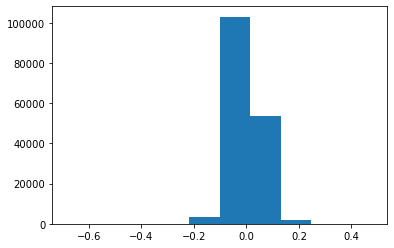

In [58]:
plt.hist(proj_id.numpy().flatten())

In [1]:
fig, axs = plt.subplots(3, 3, figsize=(30, 8), sharex=True, sharey=True, gridspec_kw = {
    'height_ratios' : [1, 1, 0.35], 'wspace' : 0.3, 'hspace' : .2
})


vmax = max(np.abs(proj_id).max(), np.abs(proj_ood).max())
vmin = -vmax

vmax_norm = max(np.abs(proj_id_norm).max(), np.abs(proj_ood_norm).max())
vmin_norm = -vmax_norm

vmax_reco = max(np.abs(proj_id_reco).max(), np.abs(proj_ood_reco).max())
vmin_reco = -vmax_reco

# Upper row, id instances
im = axs[0, 0].imshow((proj_id.numpy()), aspect='auto', vmin=vmin, vmax=vmax, cmap='PiYG')
# cbar = fig.colorbar(im, cax=axs[0, 1], ax=axs[0, 0], drawedges=False)
cbar = colorbar(im)# , label='Activation')

im = axs[0, 1].imshow((proj_id_reco.numpy()), aspect='auto', vmin=vmin_reco, vmax=vmax_reco, cmap='PiYG')
cbar = colorbar(im)# , label='Activation')

im = axs[0, 2].imshow((proj_id_norm.numpy()), aspect='auto', vmin=vmin_norm, vmax=vmax_norm, cmap='PiYG')
cbar = colorbar(im, label='Activation')

# Lower row, ood instances
im = axs[1, 0].imshow((proj_ood.numpy()), aspect='auto', vmin=vmin, vmax=vmax, cmap='PiYG')
cbar = colorbar(im) #, label='Activation')
im = axs[1, 1].imshow((proj_ood_reco.numpy()), aspect='auto', vmin=vmin_reco, vmax=vmax_reco, cmap='PiYG')
cbar = colorbar(im) #, label='Activation')
im = axs[1, 2].imshow((proj_ood_norm.numpy()), aspect='auto', vmin=vmin_norm, vmax=vmax_norm, cmap='PiYG')
cbar = colorbar(im, label='Activation')

# Spectrum

#vmin, vmax = min(log_svs[-1].min(), log_svs_norm[-1].min()), max(log_svs[-1].max(), log_svs_norm[-1].max())

axs[2, 0].set_ylim(0.0, .5)
im = axs[2, 0].imshow(np.log(svs['backbone.conv0.lin.weight'][-2]).reshape((1, -1)), aspect='auto') #, vmin=vmin, vmax=vmax)
# remove_ticks(axs[2, 0])
despine(axs[2, 0])
axs[2, 0].tick_params(axis='y', labelleft=False, left=False)
cbar = colorbar(im, label='')
# cbar.remove()


axs[2, 1].set_ylim(0.0, .5)
im = axs[2, 1].imshow(np.log(svs_reco['backbone.conv0.lin.weight'][-2]).reshape((1, -1)), aspect='auto') #, vmin=vmin, vmax=vmax)
# remove_ticks(axs[2, 0])
despine(axs[2, 1])
axs[2, 1].tick_params(axis='y', labelleft=False, left=False)
cbar = colorbar(im, label='')
# cbar.remove()

axs[2, 2].set_ylim(0.0, .5)
im = axs[2, 2].imshow(np.log(svs_norm['backbone.conv0.lin.weight'][-2]).reshape((1, -1)), aspect='auto') #, vmin=vmin, vmax=vmax)
axs[2, 2].tick_params(axis='y', labelleft=False, left=False)
cbar = colorbar(im, label='Log\nMagnitude')
cbar.set_label('Log\nMagnitude', labelpad=39)
# cbar.remove()

for ax in axs.flatten():
    despine(ax)
    ax.tick_params(axis='y', labelleft=False, left=False)
    
axs[0, 0].set_ylabel('In Distribution\nInstances')
axs[1, 0].set_ylabel('Out of Distribution\nInstances')
axs[2, 0].set_xlabel('Singular Value Index')
axs[2, 1].set_xlabel('Singular Value Index')
axs[2, 2].set_xlabel('Singular Value Index')
axs[0, 0].set_title('Vanilla GCN', fontsize=10)
axs[0, 1].set_title('GCN + Reco', fontsize=10)
axs[0, 2].set_title('GCN + Spectral Norm.', fontsize=10)
#axs[2, 0].set_title('Singular Value Log Magnitude', fontsize=10)
#axs[2, 1].set_title('Singular Value Log Magnitude', fontsize=10)

fig.savefig(f'on_the_fly_nbs/spectral_activation_{dataset}.pdf', bbox_inches='tight')

NameError: name 'plt' is not defined

In [60]:
proj_ood_norm

tensor([[ 0.1531, -0.0906, -0.0726,  ..., -0.0105,  0.0195, -0.0073],
        [ 0.1435, -0.0674, -0.0630,  ..., -0.0182, -0.0044, -0.0100],
        [ 0.1528, -0.0742, -0.0552,  ..., -0.0100,  0.0118, -0.0048],
        ...,
        [ 0.1493, -0.0694, -0.0524,  ..., -0.0237,  0.0130, -0.0116],
        [ 0.1527, -0.0874, -0.0637,  ..., -0.0196,  0.0342, -0.0077],
        [ 0.1496, -0.0711, -0.0520,  ..., -0.0155,  0.0038, -0.0106]])

In [39]:
svs_norm['backbone.conv0.lin.weight'][-2], svs['backbone.conv0.lin.weight'][-1]


(array([202.51599 , 196.48978 , 193.58908 , 190.53862 , 175.95087 ,
        164.94637 , 149.4261  ,  93.86729 ,  91.11267 ,  89.566696,
         87.67671 ,  86.72374 ,  85.44116 ,  85.20242 ,  84.02188 ,
         83.41676 ,  82.590294,  82.47713 ,  82.17743 ,  81.23896 ,
         80.784   ,  80.46839 ,  79.61956 ,  79.33398 ,  78.43669 ,
         78.0435  ,  77.58309 ,  77.26947 ,  77.01381 ,  76.31864 ,
         76.005394,  75.86391 ,  75.48595 ,  74.10208 ,  73.97775 ,
         73.39099 ,  73.17402 ,  72.72018 ,  71.96906 ,  71.35384 ,
         71.03029 ,  70.66654 ,  70.15733 ,  69.4818  ,  69.42637 ,
         68.6369  ,  67.8568  ,  67.61232 ,  67.253586,  65.89869 ,
         65.684494,  64.87748 ,  64.62516 ,  64.132545,  63.577   ,
         63.05016 ,  62.81781 ,  61.654446,  61.151833,  60.588806,
         59.853577,  58.02627 ,  55.993965,  52.684994], dtype=float32),
 array([7.3501763 , 7.2486806 , 6.946571  , 6.870964  , 6.6507473 ,
        6.077342  , 5.9281993 , 0.6253382 ,

In [40]:
u, s, v = np.linalg.svd(model_norm.backbone.convs[0].conv.lin.linear.weight.detach().cpu().numpy(), full_matrices=False)

In [41]:
s

array([202.30739 , 196.28737 , 193.38966 , 190.34235 , 175.76962 ,
       164.77646 , 149.27217 ,  93.77059 ,  91.018814,  89.47444 ,
        87.586395,  86.63441 ,  85.35315 ,  85.11466 ,  83.93533 ,
        83.33083 ,  82.50522 ,  82.392166,  82.09278 ,  81.15527 ,
        80.70078 ,  80.385506,  79.53755 ,  79.25226 ,  78.355896,
        77.96311 ,  77.503174,  77.18988 ,  76.93448 ,  76.24003 ,
        75.9271  ,  75.78576 ,  75.40819 ,  74.02575 ,  73.90155 ,
        73.31539 ,  73.09864 ,  72.64527 ,  71.89493 ,  71.28034 ,
        70.95712 ,  70.59375 ,  70.08507 ,  69.410225,  69.35486 ,
        68.5662  ,  67.786896,  67.54268 ,  67.18431 ,  65.83081 ,
        65.61684 ,  64.810646,  64.558586,  64.06648 ,  63.51151 ,
        62.985214,  62.7531  ,  61.59094 ,  61.08884 ,  60.526394,
        59.79192 ,  57.9665  ,  55.936287,  52.630722], dtype=float32)